In [9]:
import sys, os
import numpy as np
import scipy as sp
from typing import List, Tuple, Callable, Any, Dict

from methods.PolyCG.polycg.SO3 import so3
from methods.PolyCG.polycg.transforms.transform_SO3 import euler2rotmat_so3
from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.midstep_composites import midstep_composition_transformation, midstep_se3_groundstate
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
from methods.free_energy import midstep_excess_vals, calculate_midstep_triads

from methods.PolyCG.polycg.cgnaplus import cgnaplus_bps_params

np.set_printoptions(linewidth=250,precision=5,suppress=True)

### Generate stiffness and read midstep triads

In [10]:
genstiff = GenStiffness(method='MD')

# seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
seq = seq601

stiff,gs = genstiff.gen_params(seq)

triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)

midstep_locs = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]

midstep_triads = calculate_midstep_triads(
    midstep_locs,
    nuctriads
)

### calculate groundstate

In [11]:
# find composite transformation
transform, replaced_ids = midstep_composition_transformation(
    gs,
    midstep_locs
)

# transform stiffness matrix
inv_transform = np.linalg.inv(transform)
stiffmat_transformed = inv_transform.T @ stiff @ inv_transform

# rearrange stiffness matrix
full_replaced_ids = list()
for i in range(len(replaced_ids)):
    full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]

P = send_to_back_permutation(len(stiff),full_replaced_ids)
stiffmat_rearranged = P @ stiffmat_transformed @ P.T

# select fluctuating, constraint and coupling part of matrix
N  = len(stiff)
NC = len(full_replaced_ids)
NF = N-NC

MF = stiffmat_rearranged[:NF,:NF]
MC = stiffmat_rearranged[NF:,NF:]
MM = stiffmat_rearranged[NF:,:NF]

# calculate composite values
excess_vals = midstep_excess_vals(
    gs,
    midstep_locs,
    midstep_triads
)
C = excess_vals.flatten()



### Methods

In [545]:
def transformed_coordinates_stiffmat(groundstate,stiffmat,midstep_locs):

    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        groundstate,
        midstep_locs
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
    
    P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
    stiffmat_rearranged = P @ stiffmat_transformed @ P.T

    # select fluctuating, constraint and coupling part of matrix
    N  = len(stiffmat)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    MF = stiffmat_rearranged[:NF,:NF]
    MC = stiffmat_rearranged[NF:,NF:]
    MM = stiffmat_rearranged[NF:,:NF]
    
    data = {}
    data['full'] = stiffmat_rearranged
    data['orig'] = MF
    data['comp'] = MC
    data['coup'] = MM
    
    data['comp_marginal'] = MC - MM @ np.linalg.inc(MF) @ MM.T
    
    

In [546]:
def transformed_coordinates_stiffmat(groundstate,stiffmat,midstep_locs):
    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        groundstate,
        midstep_locs
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    stiffmat_transformed = inv_transform.T @ stiffmat @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
    
    P = send_to_back_permutation(len(stiffmat),full_replaced_ids)
    stiffmat_rearranged = P @ stiffmat_transformed @ P.T

    # select fluctuating, constraint and coupling part of matrix
    N  = len(stiffmat)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    MF = stiffmat_rearranged[:NF,:NF]
    MC = stiffmat_rearranged[NF:,NF:]
    MM = stiffmat_rearranged[NF:,:NF]
    
    data = {}
    data['bare'] = stiffmat
    data['full'] = stiffmat_rearranged
    data['orig'] = MF
    data['comp'] = MC
    data['coup'] = MM
    
    data['comp_marginal'] = MC - MM @ np.linalg.inv(MF) @ MM.T
    data['orig_marginal'] = MF - MM.T @ np.linalg.inv(MC) @ MM
    data['F_jacob'] = np.log(np.linalg.det(transform))
    return data

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

### Define Midstep Triad indices and static triads

In [547]:
triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)

midstep_constraint_locations = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]

# active_bonds = np.ones(len(midstep_constraint_locations),dtype=bool)
# # active_bonds[0] = False
# # active_bonds[1] = False
# # active_bonds[2] = False
# # active_bonds[3] = False
# # active_bonds[4] = False
# # active_bonds[5] = False

# midstep_locs = np.array(midstep_constraint_locations)[active_bonds]
# print(midstep_locs)

### Generate Stiffness and Ground state

In [548]:
try:
    _gns = genstiff
except NameError:
    genstiff = GenStiffness(method='MD')

# seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])
seq601 = "ATCGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCGAT"
# randseq = 'TTCCACATGGATAATACAAGAGATTCATCGACGTGCTCATTTGGCATTAGGGCATCATCCTAATGAGATTCGGTGGCGCTAACAACTTCGCTGAAAGATCAGTGGAGCGAACTGCCCTACTGTTAATTGGGTACCAGACCTCCTCACATCGTTGGTAGCTCCGTTCCTCGCGGACCGCAAGGGCAAACGTCTTACGCGACATCTGTGAATCATAACTCAGTACTTTAAAGCTAGGGCGTATTATGCA'

# seq = seq601
DNA_stiff,DNA_gs = genstiff.gen_params(seq)
DNA_data = transformed_coordinates_stiffmat(DNA_gs,DNA_stiff,midstep_locs)

### Load MD Params

In [549]:
midstep_stiff_fn = 'MDParams/nuc_stiff.npy'
midstep_gs_fn    = 'MDParams/nuc_gs.npy'

nuc_midstep_stiff = np.load(midstep_stiff_fn)
nuc_midstep_gs    = np.load(midstep_gs_fn)

### Truncate $M_\chi$ and $C_\chi$

In [550]:
full_active = np.ones(len(nuc_midstep_gs),dtype=bool)
for i,act in enumerate(active_bonds):
    full_active[i*6:(i+1)*6] = act

M_Chi = nuc_midstep_stiff[:,full_active]
M_Chi = M_Chi[full_active]
C_Chi = nuc_midstep_gs[full_active]

print(M_Chi.shape)
print(C_Chi.shape)
print(is_pos_def(M_Chi))

(162, 162)
(162,)
True


### Calculate DNA groundstate between midstep triads

In [551]:
def midstep_groundstate(gs,midstep_locs):
    num = len(midstep_locs)-1
    mid_gs = np.zeros((num,6))
    for i in range(num):
        id1 = midstep_locs[i]
        id2 = midstep_locs[i+1]
        partial_gs = gs[id1:id2+1] 
        
        Smats = midstep_se3_groundstate(partial_gs)
        s_ij = np.eye(4)
        for Smat in Smats:
            s_ij = s_ij @ Smat
        mid_gs[i] = so3.se3_rotmat2euler(s_ij)
    return mid_gs

midstep_gs = midstep_groundstate(DNA_gs,midstep_locs)

### Check Sign of $C_\chi$

In [552]:
num_flips = 0
for i in range(len(midstep_gs)):
    if np.abs(C_Chi[i*6+2] - midstep_gs[i,2]) - np.abs(-C_Chi[i*6+2] - midstep_gs[i,2]) > 1:
        print(f'flip {i}')
        num_flips += 1
        C_Chi[i*6:(i+1)*6] = -C_Chi[i*6:(i+1)*6]
print(f'{num_flips} entries flipped')

0 entries flipped


### Convert constraint energy to $\Psi$ coordinates

In [553]:
from methods.PolyCG.polycg.Transforms.transform_algebra2group import algebra2group_lintrans, group2algebra_lintrans
H = algebra2group_lintrans(midstep_gs,translation_as_midstep=False)
Hinv = group2algebra_lintrans(midstep_gs)

Psi_0 = midstep_gs.flatten()
C_Psi = H @ (C_Chi - Psi_0)
M_Psi_C = Hinv.T @ M_Chi @ Hinv

M_Psi_C = M_Psi_C

print(is_pos_def(M_Psi_C))

True


### Calculate $M_{\Psi}^{(D)}$ and $\bar{\mathbf{D}}_\Psi$

In [554]:
M_Psi_m = DNA_data['comp_marginal']

M_Psi_D = M_Psi_C - M_Psi_m
M_Psi_tot = M_Psi_m + M_Psi_D
D_Psi = np.linalg.inv(M_Psi_D).T @ M_Psi_tot @ C_Psi

print(is_pos_def(M_Psi_m))
print(is_pos_def(M_Psi_D))
print(is_pos_def(M_Psi_tot))

# set off-diagonal elements to zero
nn = len(D_Psi)//6
for i in range(len(D_Psi)//6):
    for j in range(len(D_Psi)//6):
        if i!=j:
            M_Psi_D[i*6:(i+1)*6,j*6:(j+1)*6] = 0
        
print(is_pos_def(M_Psi_D))

M_Psi_tot = M_Psi_m + M_Psi_D
D_Psi = np.linalg.inv(M_Psi_D).T @ M_Psi_tot @ C_Psi

print(is_pos_def(M_Psi_m))
print(is_pos_def(M_Psi_D))
print(is_pos_def(M_Psi_tot))



True
False
True
True
True
True
True


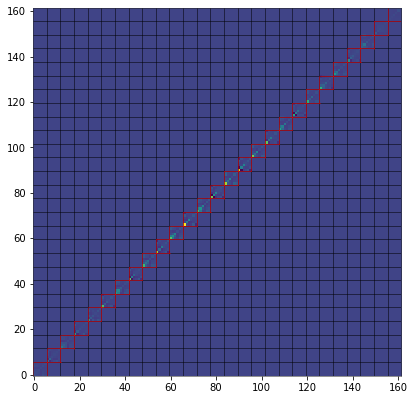

In [555]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
stiff = M_Psi_D
dims = 6

fig = plt.figure(figsize=(17./2.54,17.2/2.54))
ax1 = fig.add_subplot(111)
# Bilinear interpolation - this will look blurry
ax1.imshow(stiff, interpolation='none', cmap='viridis')
i
# plot blocks
for l in range(1,len(stiff)//dims+1):
    ax1.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(stiff)-0.5],color='black',lw=0.5)
    ax1.plot([0-0.5,len(stiff)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

    ax1.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax1.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
    ax1.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
    ax1.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
    
    
ax1.set_xlim((-0.5,len(stiff)-.5))
ax1.set_ylim((-0.5,len(stiff)-.5))

# ax1.set_xlim((-0.5,12-.5))
# ax1.set_ylim((-0.5,12-.5))

plt.show()

### Calculate Constant contribution

$\beta E_\mathrm{const} = \frac{1}{2} \left.\bar{\mathbf{D}}_\Psi\right.^\intercal \left( M_\Psi^{(D)} - M_\Psi^{(D)} \left.M_\Psi^{(tot)}\right.^{-1} \left.M_\Psi^{(D)}\right.^\intercal \right) \bar{\mathbf{D}}_\Psi$

In [556]:
M_D_renorm = M_Psi_D - M_Psi_D @ np.linalg.inv(M_Psi_tot) @ M_Psi_D.T
E_const = 0.5*D_Psi.T @ M_D_renorm @ D_Psi
print(E_const)

132.36249348410476


### Extend the full system

In [557]:
M_all = DNA_data['full']
M_D = np.zeros(M_all.shape)
D   = np.zeros(len(M_all))

nd = len(D_Psi)
M_D[-nd:,-nd:] = M_Psi_D
D[-nd:] = D_Psi

M_tot = M_all + M_D
alpha = np.linalg.inv(M_tot) @ M_D.T @ D

print(is_pos_def(M_tot))
print(is_pos_def(M_Psi_D))
print(is_pos_def(M_Psi_C))

#### Calculate energies

M_D_renorm = M_D - M_D @ np.linalg.inv(M_tot) @ M_D.T
E_const = 0.5 * D.T @ M_D_renorm @ D


# entropy term
n = len(M_tot)
logdet_sign, logdet = np.linalg.slogdet(M_tot)
F_pi = -0.5*n * np.log(2*np.pi)
# matrix term
F_mat = 0.5*logdet
F_entro = F_pi + F_mat

F_jacob = DNA_data['F_jacob']


F_total = E_const + F_entro + F_jacob

print(f'E_const = {E_const}')
print(f'F_entro = {F_entro}')
print(f'F_jacob = {F_jacob}')
print(f'F_fluc = {F_entro+F_jacob}')
print(f'F_total = {F_total}')



True
True
True
E_const = 132.36248552315087
F_entro = 2009.8892949788533
F_jacob = -111.71565102413392
F_fluc = 1898.1736439547194
F_total = 2030.5361294778704


In [558]:
active_bonds = np.ones(len(midstep_constraint_locations),dtype=bool)
# active_bonds[0] = False
# active_bonds[1] = False
# active_bonds[2] = False
# active_bonds[3] = False
# active_bonds[4] = False
# active_bonds[5] = False
# active_bonds[6] = False
# active_bonds[7] = False
# active_bonds[8] = False
# active_bonds[9] = False
# active_bonds[10] = False
# active_bonds[11] = False
# active_bonds[12] = False
# active_bonds[13] = False
# active_bonds[14] = False
# active_bonds[15] = False
# active_bonds[16] = False
# active_bonds[17] = False
# active_bonds[18] = False
# active_bonds[19] = False
# active_bonds[20] = False
# active_bonds[21] = False
# active_bonds[22] = False
# active_bonds[23] = False
# active_bonds[24] = False
# active_bonds[25] = False

print(active_bonds.shape)


midstep_locs = np.array(midstep_constraint_locations)[active_bonds]
print(midstep_locs)

(28,)
[  2   6  14  17  24  29  34  38  45  49  55  59  65  69  76  80  86  90  96 100 107 111 116 121 128 131 139 143]
